# Modelando funções complexas com Redes Neurais Artificiais

In [11]:
#!pip install -q tensorflow
#!pip install -q -U keras

In [13]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np

from load_mnist import fetch_data

In [14]:
%%time
#(train_X, train_y), (test_X, test_y) = mnist.load_data()
X_train, y_train,  X_test, y_test = fetch_data()

CPU times: user 4.62 s, sys: 1.25 s, total: 5.87 s
Wall time: 6.16 s


## Implementando uma rede MLP - multi-layer perceptron

# TESTAR

In [33]:
import numpy as np
import sys

class NeuralNetMLP(object):
    
    def __init__(self, n_hidden=30,
                 l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2 # L2-regularization
        self.epochs = epochs
        self.eta = eta # Learning Rate
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size

    def _onehot(self, y, n_classes):
        
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    # NÃO ALTERAR
    def _forward(self, X):
        """Compute forward propagation step"""

        # step 1: net input of hidden layer
        # [n_samples, n_features] dot [n_features, n_hidden]
        # -> [n_samples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h

        # step 2: activation of hidden layer
        a_h = self._sigmoid(z_h)

        # step 3: net input of output layer
        # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_samples, n_classlabels]

        z_out = np.dot(a_h, self.w_out) + self.b_out

        # step 4: activation output layer
        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    # NÃO ALTERAR
    def _compute_cost(self, y_enc, output):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_samples, n_labels)
            one-hot encoded class labels.
        output : array, shape = [n_samples, n_output_units]
            Activation of the output layer (forward propagation)

        Returns
        ---------
        cost : float
            Regularized cost

        """
        L2_term = (self.l2 *
                   (np.sum(self.w_h ** 2.) +
                    np.sum(self.w_out ** 2.)))

       # np.where(output>1e-8,np.log(output),0)


        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term

        return cost

    # NÃO ALTERAR
    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.

        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    # NÃO ALTERAR
    def fit(self, X_train, y_train, X_valid, y_valid):

        
        n_output = np.unique(y_train).shape[0]  # number of class labels
        n_features = X_train.shape[1]

        # NÃO ALTERAR - Treino do Modelo

        ########################
        # Weight initialization
        ######################## 

        # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))

        # weights for hidden -> output  
        self.b_out = np.zeros(n_output) # num_classes
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))

        epoch_strlen = len(str(self.epochs))  # for progress formatting
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        y_train_enc = self._onehot(y_train, n_output)


        # NÃO ALTERAR

        # iterate over training epochs
        for i in range(self.epochs):

            # iterate over minibatches
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size +
                                   1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # forward propagation
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx]) # = len(X) X.shape[0]


                # NÃO ALTERAR
                
                ##################
                # Backpropagation
                ##################

                # [n_samples, n_classlabels]
                sigma_out = a_out - y_train_enc[batch_idx]

                # [n_samples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)

                # [n_samples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_samples, n_hidden]
                sigma_h = (np.dot(sigma_out, self.w_out.T) *
                           sigmoid_derivative_h)

                # [n_features, n_samples] dot [n_samples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
                grad_b_h = np.sum(sigma_h, axis=0)

                # [n_hidden, n_samples] dot [n_samples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis=0)

                # Regularization and weight updates
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # bias is not regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out  # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            #############
            # Evaluation
            #############

            # NÃO ALTERAR

            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float64) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float64) /
                         X_valid.shape[0])

            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

# TESTE DO MODELO - 2025

In [34]:
X = [[0., 0.], [1., 1.], [2., 2.],[3.,3.]] * 100
y = [0, 1, 2, 3] * 100



X = np.array(X)
y  = np.array(y) #, dtype=np.int16)


# print(X)
# print(X.shape)

# print(y)
# print(y.shape)

n_epochs = 100#100 
l2=0.02
nn = NeuralNetMLP(n_hidden=100, 
                  l2=l2, 
                  epochs=n_epochs, 
                  eta=0.001, # 0.1, 0.3 - 0.01, 0.1, 0.001, 0.0001
                  minibatch_size=100, # 64, 128, 256 
                  shuffle=True,
                  seed=1)


X_train, y_train, X_valid, y_valid = X, y, X, y
nn.fit(X_train, y_train, X_valid, y_valid)

100/100 | Cost: 478.96 | Train/Valid Acc.: 100.00%/100.00% 

In [35]:
i = 0
x1 = np.array(X[i]).reshape(1, -1)
nn.predict(x1)

array([0])

In [36]:
for i in range(4):
    x1 = np.array(X[i]).reshape(1, -1)
    print(nn.predict(x1))

[0]
[1]
[2]
[3]


## Treinando uma Rede Neural com as imagens de dígitos manuscritos

In [46]:
%%time 

# Aproximate training time: 14 mins, MacbookPro I5, 2.6 GHz Intel Core i5, 8 GB 1600 MHz DDR3, n_hidden=100
# Aproximate training time: 17 mins, n_hidden=200
# Aproximate training time: 20 mins, n_hidden=200, l2=0.1
# Aproximate training time: 21 mins, n_hidden=200, l2=0.02, n_epochs=200, eta=0.0005
# Aproximate training time: 6 mins, n_hidden=200, l2=0.02, n_epochs=200, 200/200 | 
#    Macbook I7,                       Cost: 5227.82 | Train/Valid Acc.: 99.29%/98.40% 

#import time
#start = time.time()
n_epochs = 15 #100 
l2=0.02
nn = NeuralNetMLP(n_hidden=100, 
                  l2=l2, 
                  epochs=n_epochs, 
                  eta=0.0005, # 0.1, 0.3 - 0.01, 0.1, 0.001, 0.0001
                  minibatch_size=100, # 64, 128, 256 
                  shuffle=True,
                  seed=1)

nn.fit(X_train=X_train[:55000], 
       y_train=y_train[:55000],
       X_valid=X_train[55000:],
       y_valid=y_train[55000:])

#end = time.time() 
#stopWatch(end-start)

15/15 | Cost: 28132.42 | Train/Valid Acc.: 92.75%/94.08% 

CPU times: user 1min 8s, sys: 15.5 s, total: 1min 24s
Wall time: 48.1 s


In [47]:
# 14/14 | Cost: 28668.96 | Train/Valid Acc.: 92.41%/94.38% 
# Tempo Decorrido: 0:0:48
# Test accuracy: 92.02%

# Salvando o modelo para o disco 

In [48]:
# O Modelo
nn

In [49]:
atributos = list( nn.__dict__.keys() )
print('Atributos: ', atributos, sep="\n")

Atributos: 
['random', 'n_hidden', 'l2', 'epochs', 'eta', 'shuffle', 'minibatch_size', 'b_h', 'w_h', 'b_out', 'w_out', 'eval_']


In [50]:
print('Atributos:\n', '\n+'.join(atributos))

Atributos:
 random
+n_hidden
+l2
+epochs
+eta
+shuffle
+minibatch_size
+b_h
+w_h
+b_out
+w_out
+eval_


In [54]:
import pickle
# save the model to disk
filename = 'neuralnet_model.pickle'
print('Saving file ' + filename + '...')
pickle.dump(nn, open(filename, 'wb'))
print('File Saved ' + filename + '.') 

Saving file neuralnet_model.pickle...
File Saved neuralnet_model.pickle.


# Carregando o modelo do disco

In [56]:
# load the model from disk
print('Loading file' + filename + '...')
loaded_model = pickle.load(open(filename, 'rb'))
predict = loaded_model.predict(X_test)
result = sum(predict == y_test) / len(predict)
print(result)

Loading fileneuralnet_model.pickle...
0.9282


## Exibindo as métricas da Rede Neural

In [57]:
print('cost:', np.mean(nn.eval_['cost']))
print('train_acc:', np.mean(nn.eval_['train_acc']))
print('valid_acc:', np.mean(nn.eval_['valid_acc']))
nn.w_out[0]

cost: 35307.482901325246
train_acc: 0.908140606060606
valid_acc: 0.9299599999999999


array([-0.39935389,  0.41406761, -0.58832102, -0.29523166,  0.24262292,
       -0.44686358, -0.36571072,  0.26041342, -0.91597906,  0.1763496 ])


---

## Plotando análises

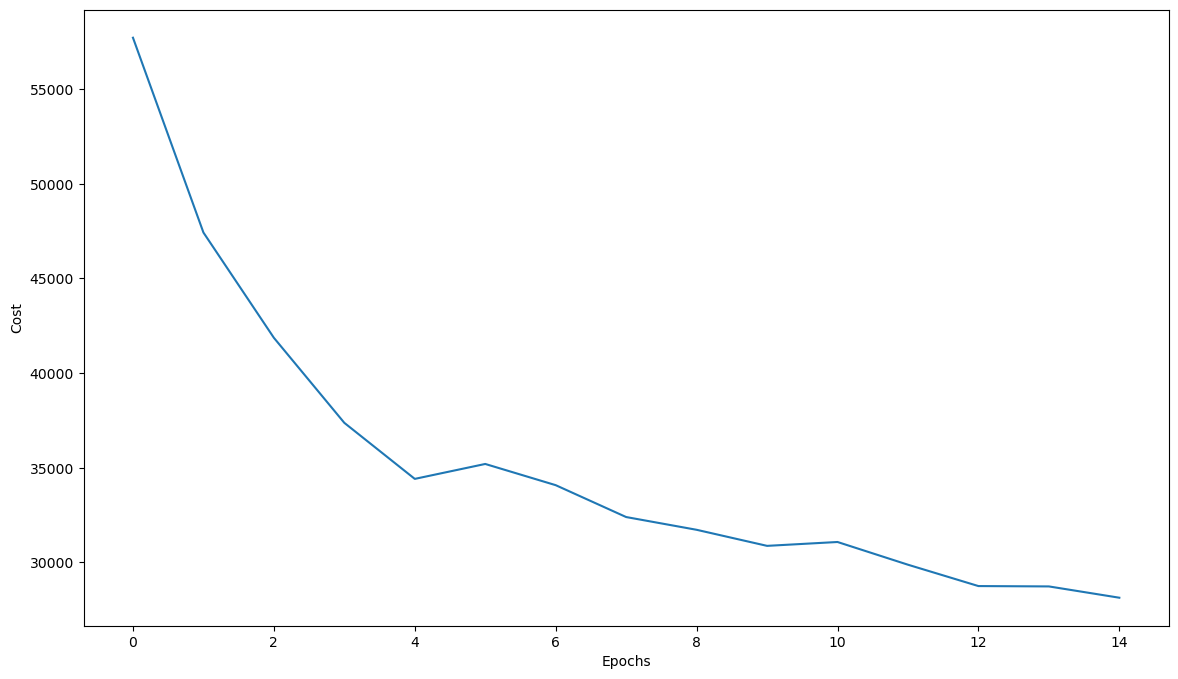

In [58]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [14,8]

plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
#plt.savefig('images/12_07.png', dpi=300)
plt.show()

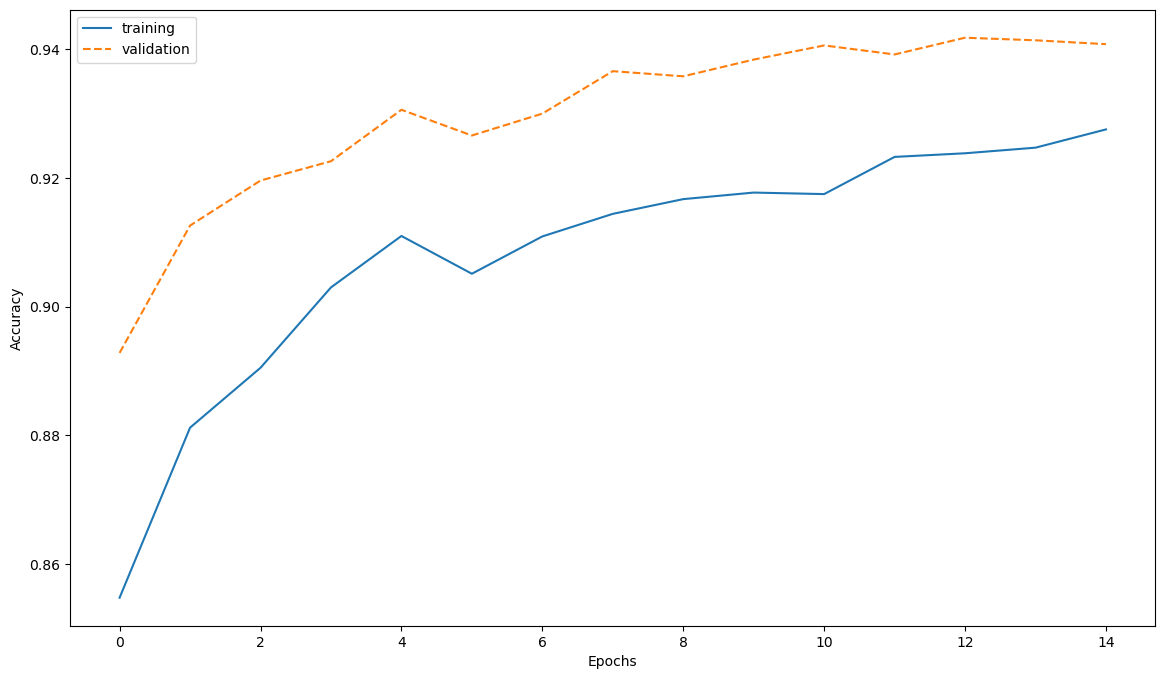

In [59]:
plt.plot(range(nn.epochs), nn.eval_['train_acc'], 
         label='training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], 
         label='validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
#plt.savefig('images/12_08.png', dpi=300)
plt.show()

In [60]:
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred)
       .astype(np.float64) / X_test.shape[0])

print('Test accuracy: %.2f%%' % (acc * 100))

Test accuracy: 92.82%


## Plotando algumas predições erradas do conjunto de teste 

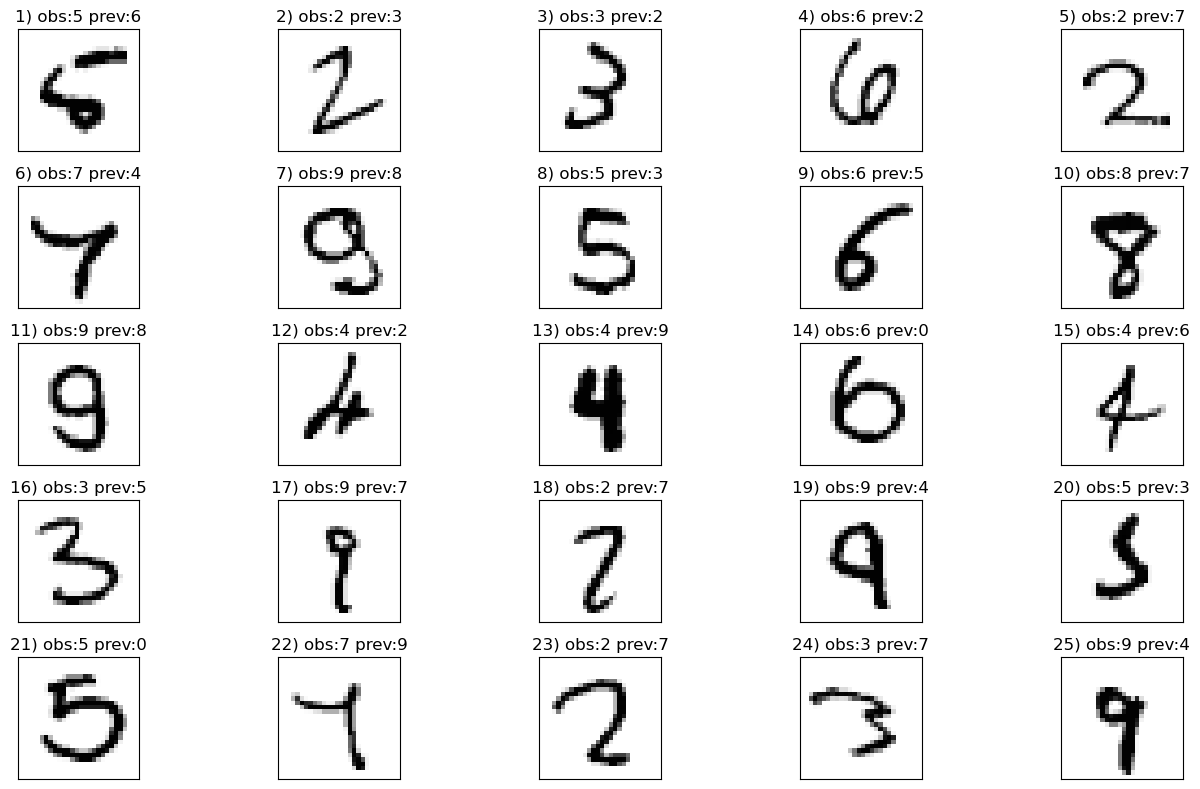

In [61]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) obs:%d prev:%d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.rcParams["figure.figsize"] = [14,8]
plt.show()

---